In [ ]:
!pip install spacy
!pip install nltk
!pip install SimpSom
!pip install gensim

  Created wheel for SimpSom: filename=SimpSOM-1.3.4-cp37-none-any.whl size=17086 sha256=fa9a5abe8c10b1004dcb9a092039fe0e7c16a10b8109b3b34830c52eb37ea839
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built SimpSom


In [ ]:
%cd "/content/drive/MyDrive/DSPM_Project"

/content/drive/MyDrive/DSPM_Project


In [ ]:
!pwd

/content/drive/MyDrive/DSPM_Project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import SimpSOM as sps
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.decomposition import TruncatedSVD

# Load the Top Product Reviews Data and Create a Subset from one product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reviews= pd.read_json("top_prod_reviews.json",compression="gzip")
reviews.head()

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
2543,1,0,A1SJGHZDQHVYWH,B000142FVW,Julie D. Cassetina,Doesnt match the regular color of the real pro...,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2544,3,0,A1EZAX4P346ABG,B000142FVW,James C. James,Not pigmented enough. Needed three coats and s...,Low pigment,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2545,4,0,A1AT61K23ZY13Z,B000142FVW,Amazon Customer,I really liked the color of this polish. It wa...,I really liked the color of this polish,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2546,5,0,A326K7TN4PZE82,B000142FVW,DJ Curtiss,"Opi is the best quality polish I've used, and ...",Sturdy and Pretty Colors,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2547,1,0,AHHXLXF3I7BWW,B000142FVW,Angelica,Its counterfeit :/,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...


In [ ]:
prod1= reviews[reviews['asin']=="B000142FVW"]
prod1.shape

(3051, 16)

# Text Preparation

In [ ]:
prod1['reviewText']= prod1['reviewText'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
nlp= spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("color")
nlp.Defaults.stop_words.add("polish")
nlp.Defaults.stop_words.add("nails")
nlp.Defaults.stop_words.add("opi")
nlp.Defaults.stop_words.add("pink")

In [ ]:
def remove_stopwords(text):
  '''
  Args

  text : a string of product review

  Return:

  tokens: a list of tokens without stopwords and punctutaions
  '''
  tokens=[]
  doc=nlp(text)
  for word in doc:
    if word.is_stop==False:
      if word.is_punct==False:
        if word.pos_=='ADJ' or word.pos_=="NOUN" or word.pos_=="VERB":
          tokens.append(word.text)
  
  return tokens

In [ ]:
prod1['reviewsTokens']=prod1['reviewText'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# K-Means Clustering with Word2Vec Model

## Word2Vec Model

In [ ]:
sent = [row for row in prod1['reviewsTokens'].to_list()]

In [ ]:
wv_model= Word2Vec(min_count=5,window=4,size=300)

In [ ]:
wv_model.build_vocab(sent)

In [ ]:
wv_model.train(sent, total_examples= wv_model.corpus_total_words,epochs=30, report_delay=1)
wv_model.init_sims(replace=True)

In [ ]:
wv_model.save("w2vModel_prod1.model")

In [ ]:
word_vectors= Word2Vec.load("w2vModel_prod1.model").wv

In [ ]:
word_vectors.vectors.shape

(662, 300)

## K Means Clustering with Word2Vec

In [ ]:
model_kmeans=KMeans(n_clusters=2, max_iter=10000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [68]:
word_vectors.similar_by_vector(model_kmeans.cluster_centers_[1], topn=20,restrict_vocab=None)

[('peach', 0.9982423186302185),
 ('fantastic', 0.9979265332221985),
 ('effect', 0.9979056119918823),
 ('brighter', 0.9975956082344055),
 ('cute', 0.9972516298294067),
 ('depending', 0.9971951842308044),
 ('simple', 0.9967758059501648),
 ('glitter', 0.9967131018638611),
 ('hits', 0.9958677291870117),
 ('silver', 0.9958299398422241),
 ('noticeable', 0.9956555962562561),
 ('pastel', 0.9954335689544678),
 ('tint', 0.9953662157058716),
 ('brilliant', 0.9952573776245117),
 ('extra', 0.9952077865600586),
 ('depth', 0.9951438307762146),
 ('year', 0.9944156408309937),
 ('toenails', 0.9943919777870178),
 ('feminine', 0.9943734407424927),
 ('disappoint', 0.9942153096199036)]

In [ ]:
positive_cluster_index = 1
positive_cluster_center = model_kmeans.cluster_centers_[positive_cluster_index]
negative_cluster_center = model_kmeans.cluster_centers_[1-positive_cluster_index]

In [ ]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model_kmeans.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model_kmeans.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [ ]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,match,"[-0.031531267, -0.12426217, 0.05267279, 0.0406...",0,-1,3.285208,-3.285208
1,regular,"[-0.042087007, -0.10731944, 0.0351901, 0.04371...",0,-1,5.635247,-5.635247
2,real,"[-0.01066269, -0.11327187, 0.10037646, 0.04296...",0,-1,1.502013,-1.502013
3,product,"[-0.0060829725, -0.11675766, 0.10049102, 0.054...",0,-1,1.729212,-1.729212
4,pigmented,"[-0.043290984, -0.09523768, 0.010237722, 0.043...",1,1,6.583132,6.583132
5,needed,"[-0.05174659, -0.091311365, 0.0141729815, 0.04...",1,1,2.545182,2.545182
6,coats,"[-0.03465712, -0.053618997, -0.05462477, 0.028...",1,1,1.341169,1.341169
7,beautiful,"[-0.044239763, -0.06046371, -0.029840065, 0.02...",1,1,2.799255,2.799255
8,elegant,"[-0.04648721, -0.07931364, -0.00820155, 0.0341...",1,1,6.982766,6.982766
9,time,"[-0.04299949, -0.0642646, 0.031247204, 0.03518...",1,1,1.652718,1.652718


In [ ]:
words[['words', 'sentiment_coeff']].to_csv('prod1_sentiment_dictionary.csv', index=False)

## TF-IDF Vectorizer and Word2Vec Vectors

In [ ]:
prod1['token_sent']= prod1['reviewsTokens'].apply(lambda x: ' '.join(w for w in x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tf= TfidfVectorizer(tokenizer=remove_stopwords)
tf.fit(prod1['reviewText'])
features=pd.Series(tf.get_feature_names())
transformed = tf.transform(prod1['reviewText'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
prod1_justtxt= prod1['token_sent'].reset_index().drop('index',axis=1)

In [ ]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    Return:

    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    Args:

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    Return:
    list: replacing each word with it's calculated tfidf dictionary with scores of each word

    Args:
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.token_sent.split()))

In [ ]:
replaced_tfidf_scores = prod1_justtxt.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

In [ ]:
replaced_tfidf_scores

0       [0.36171752886774694, 0.44404247073160935, 0.3...
1       [0.4715442275894245, 0.39446539949786297, 0.54...
2       [0.2539407991435306, 0.21705893697687592, 0.27...
3       [0.32276195320452683, 0.28666239846273023, 0.1...
4                                                   [1.0]
                              ...                        
3046    [0.06419033305556576, 0.21235742238661362, 0.1...
3047             [0.5117781035427506, 0.8591176710638572]
3048    [0.2824432802366036, 0.33071854625014085, 0.90...
3049    [0.4051806366123765, 0.5854383369197557, 0.397...
3050              [0.648782278723036, 0.7609740828799264]
Length: 3051, dtype: object

In [ ]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    Return
    replacing each word with its associated sentiment score from sentiment dict

    Args:
    word: single token text
    sentiment_dict: Dictionary created with Word2Vec Model with K Means Clustering
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [ ]:
sentiment_map = pd.read_csv('prod1_sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [ ]:
replaced_closeness_scores = prod1.token_sent.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split()))).reset_index()

## Prediction Using Sentiment Coefficients and TF-IDF Scores

In [ ]:
prod1['rate']=prod1['overall'].apply(lambda x: 1 if x>3 else -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
replaced_closeness_scores=replaced_closeness_scores.drop('index',axis=1).squeeze()
prod1_reviews= prod1['reviewText'].reset_index().drop('index',axis=1).squeeze()
prod1_rate= prod1['rate'].reset_index().drop('index',axis=1).squeeze()

In [ ]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, prod1_reviews, prod1_rate]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']

In [ ]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment
0,"[-3.2852084608391694, -5.635246746172752, -1.5...","[0.36171752886774694, 0.44404247073160935, 0.3...",doesnt match the regular color of the real pro...,-1
1,"[6.583132236546428, 2.545181929499248, 1.34116...","[0.4715442275894245, 0.39446539949786297, 0.54...",not pigmented enough. needed three coats and s...,-1
2,"[-3.595733016904669, 1.5312165860757143, -10.0...","[0.2539407991435306, 0.21705893697687592, 0.27...",i really liked the color of this polish. it wa...,1
3,"[6.225465038608147, -3.786508837034509, 2.8113...","[0.32276195320452683, 0.28666239846273023, 0.1...","opi is the best quality polish i've used, and ...",1
4,[-5.719213893603307],[1.0],its counterfeit :/,-1


In [ ]:
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

In [ ]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[-3.2852084608391694, -5.635246746172752, -1.5...","[0.36171752886774694, 0.44404247073160935, 0.3...",doesnt match the regular color of the real pro...,0,-4.608389,0
1,"[6.583132236546428, 2.545181929499248, 1.34116...","[0.4715442275894245, 0.39446539949786297, 0.54...",not pigmented enough. needed three coats and s...,0,9.746264,1
2,"[-3.595733016904669, 1.5312165860757143, -10.0...","[0.2539407991435306, 0.21705893697687592, 0.27...",i really liked the color of this polish. it wa...,1,-5.294105,0
3,"[6.225465038608147, -3.786508837034509, 2.8113...","[0.32276195320452683, 0.28666239846273023, 0.1...","opi is the best quality polish i've used, and ...",1,3.226346,1
4,[-5.719213893603307],[1.0],its counterfeit :/,0,-5.719214,0


In [ ]:
replacement_df.to_json('prod1_KmeansWord2Vec_predictions.json',compression='gzip')

## Evaluating the K-Means with Word2Vec Model for Product 1

In [ ]:
acc= accuracy_score(replacement_df['sentiment'],replacement_df['prediction'])
precision= precision_score(replacement_df['sentiment'],replacement_df['prediction'])
recall= recall_score(replacement_df['sentiment'],replacement_df['prediction'])
f1= f1_score(replacement_df['sentiment'],replacement_df['prediction'])

In [ ]:
acc

0.6866601114388725

In [ ]:
precision

0.899890590809628

In [ ]:
recall

0.6803143093465674

In [ ]:
f1

0.7748469147432877

In [ ]:
scores= [acc,precision,recall,f1]
with open("prod1_Kmeans_Word2Vec_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i)

# K-Means Clustering with Simple Self-Organized Maps for Product1

In [ ]:
tf= TfidfVectorizer(tokenizer=remove_stopwords)
reviews_data= tf.fit_transform(prod1['reviewText'])
svd= TruncatedSVD(100,random_state=42)
reviews_de= svd.fit_transform(reviews_data)

In [ ]:
net= sps.somNet(20,20,reviews_de,PBC=True)

Periodic Boundary Conditions active.
The weights will be initialised randomly.


In [ ]:
net.train(0.01,5000)

Training SOM... done!


In [ ]:
net.save('weightsSOM_prod1')

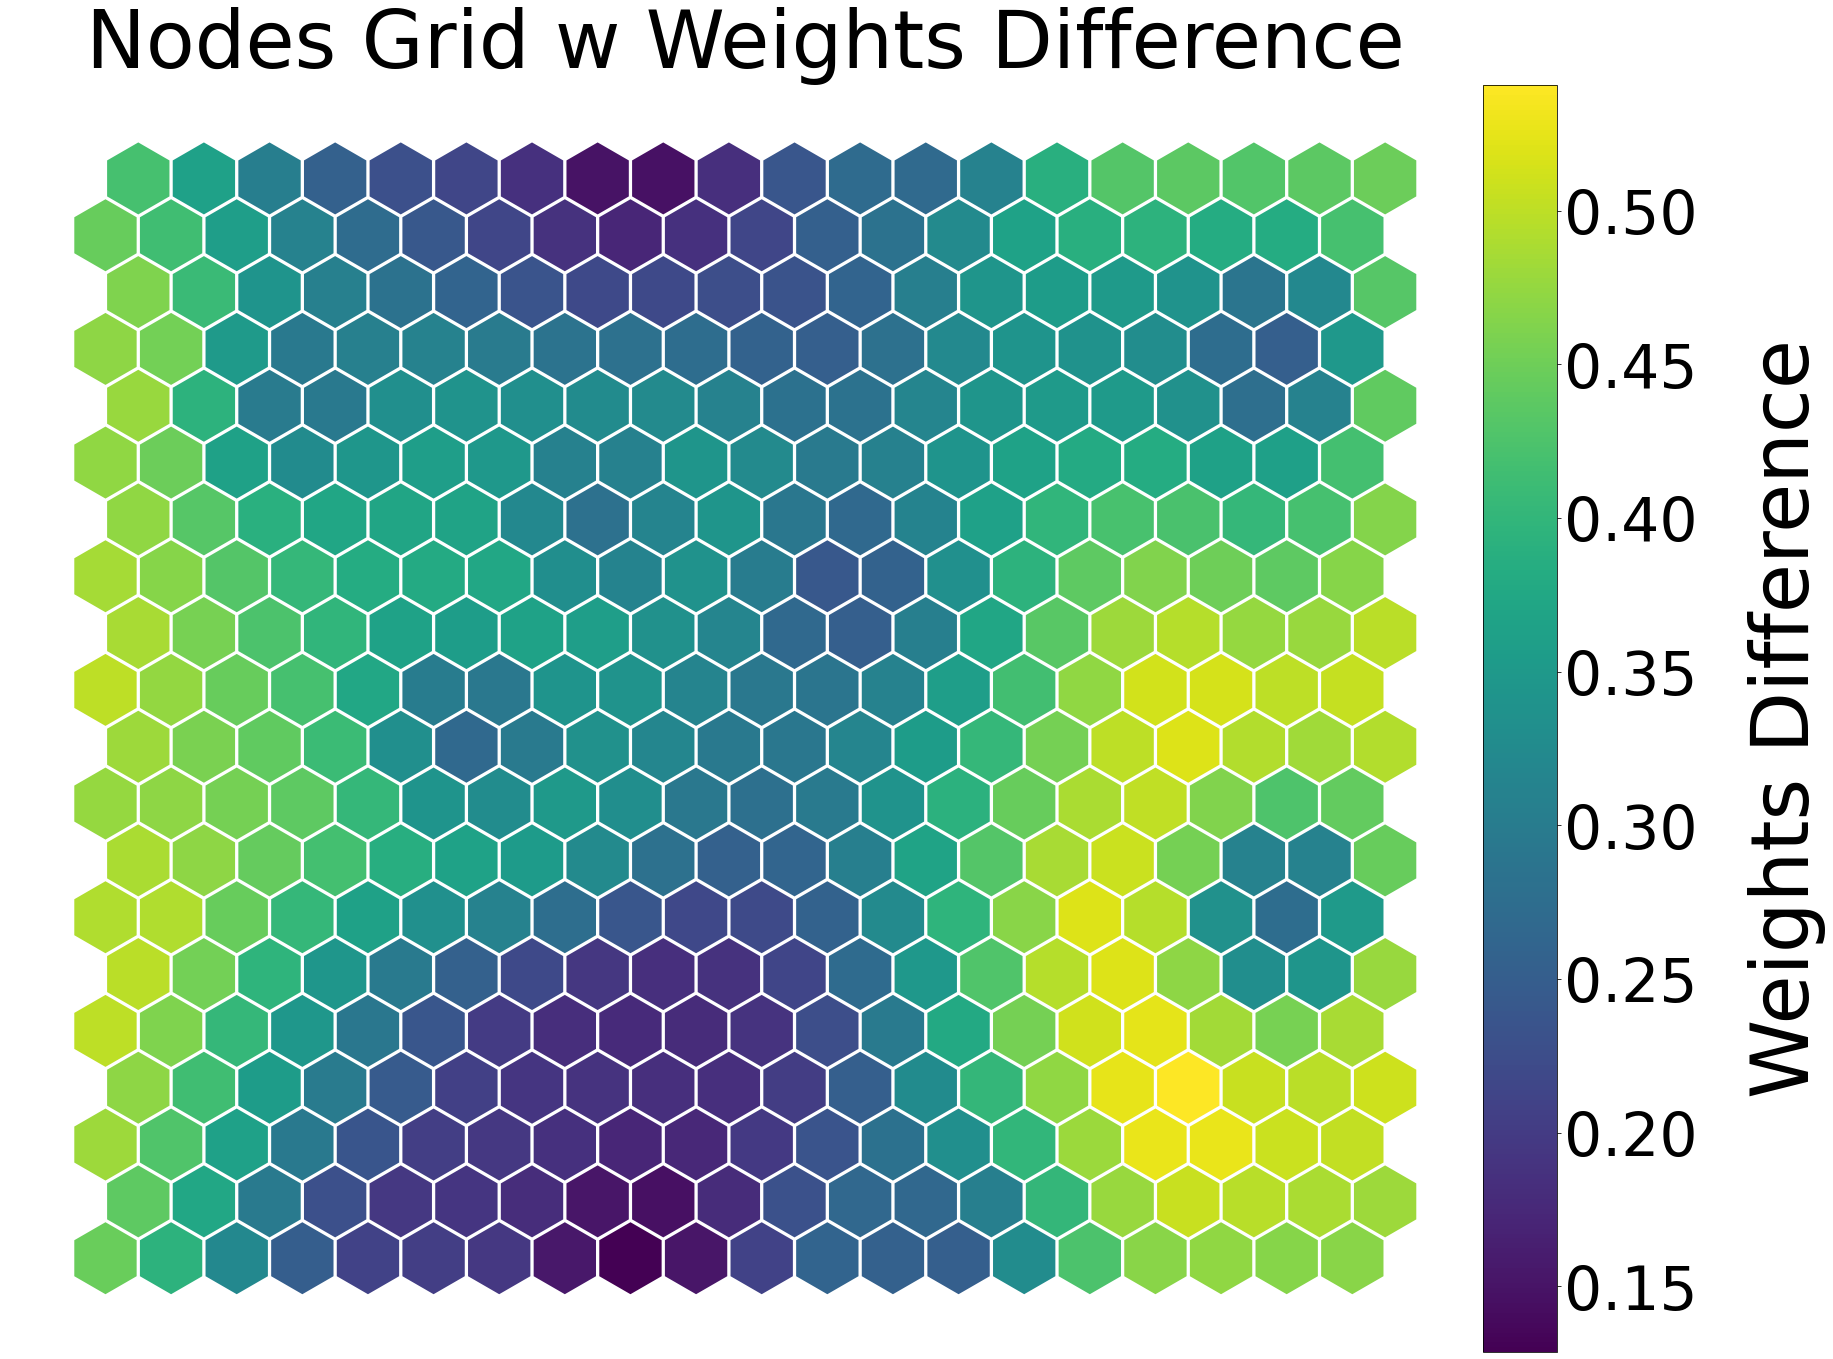

In [ ]:
net.diff_graph()

In [ ]:
prj= np.array(net.project(reviews_de))

<Figure size 432x288 with 0 Axes>

In [ ]:
prod1_som= prod1[['reviewText','rate']].reset_index().drop('index',axis=1)
prod1_som.rename(columns={'rate':'sentiment'},inplace=True)
prod1_som.head()


,reviewText,sentiment
0,doesnt match the regular color of the real pro...,-1
1,not pigmented enough. needed three coats and s...,-1
2,i really liked the color of this polish. it wa...,1
3,"opi is the best quality polish i've used, and ...",1
4,its counterfeit :/,-1


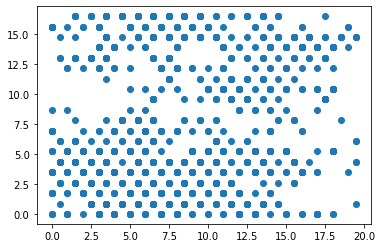

In [ ]:
plt.scatter(prj.T[0],prj.T[1])
plt.show()

In [ ]:
kmeans= KMeans(n_clusters=2,random_state=True).fit(prj)

In [ ]:
prod1_som['prediction']=kmeans.labels_

In [ ]:
prod1_som[prod1_som['prediction']==0].head()

,reviewText,sentiment,prediction
1,not pigmented enough. needed three coats and s...,-1,0
3,"opi is the best quality polish i've used, and ...",1,0
13,as always a great color,1,0
14,"this, to me, is the absolute perfect sheer nud...",1,0
19,great color and fast shipping!,1,0


In [ ]:
prod1_som['sentiment']=prod1_som['sentiment'].apply(lambda x: 1 if x==1 else 0)

In [ ]:
prod1_som.to_json('prod1_KmeansSOM.json',compression='gzip')

In [ ]:
acc=accuracy_score(prod1_som['sentiment'],prod1_som['prediction'])

In [ ]:
precision=precision_score(prod1_som['sentiment'],prod1_som['prediction'])

In [ ]:
recall=recall_score(prod1_som['sentiment'],prod1_som['prediction'])

In [ ]:
f1= f1_score(prod1_som['sentiment'],prod1_som['prediction'])

In [ ]:
acc,precision,recall,f1

(0.46148803670927563,
 0.7111716621253406,
 0.5397022332506204,
 0.6136844580296262)

In [ ]:
scores= [acc,precision,recall,f1]
with open("prod1_Kmeans_SOM_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i)